# PuLP solvers comparison

This notebook compares the performance of different solvers in PuLP using a capacitated vehicle positioning problem as an example. The problem is formulated as a mixed-integer linear programming problem (MILP) and solved using three different solvers: PULP_CBC (COIN-OR Branch and Cut), GLPK (GNU Linear Programming Kit), and HiGHS (High-Performance Solver). The performance of the solvers is compared in terms of the solution time and the objective value.


In [16]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-29T17:10:43.100511+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import pulp
import highspy

pd.set_option('display.float_format', lambda x: '%.3f' % x)
# ox.settings.log_console=True
# ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

geopandas : 0.14.3
numpy     : 1.26.4
highspy   : 1.5.3
matplotlib: 3.8.3
pulp      : 2.8.0
pandas    : 2.2.1



### Problem formulation:
- The objective function is to minimize the total response time of the police vehicles to events in their district.
- The constraints include 
    - a fixed number of police car locations
    - each event must be assigned to exactly one police car.
    - A police car can be assigned to an event only if it's placed at the corresponding location.
    - Each police car has a maximum capacity of events it can respond to (M).
- Complexity and Model Scalability: The presence of binary variables (x,y) transforms your problem into a Mixed-Integer Linear Programming (MILP) problem, inherently making it NP-hard. This complexity means that solving time can increase exponentially with the size of your data or the constraints of your problem

### Problem characteristics:
- The problem has 30 cars and over 2286 locations.
- The CostMatrix which holds the pairs of car nodes, event nodes and the cost of travel between them is a 30x2286 matrix (68580 elements). This can be considered a large-scale linear programming problem.
- The problem's density (ratio of non-zero entries in the cost matrix to the total possible entries) is usually sparse for road networks. Sparse problems have many zero or near-zero elements in their matrices, implying that not every police car location has a direct path to every event, which is typical in real-world road networks.

### Suggested methods:
Method often depends on the problem's specific characteristics, such as its size, density, and the nature of its constraints and variables.
- **Simplex Method**: Primarily used for solving linear programming problems, the Simplex method iterates through vertices of the feasible region in the direction of increasing value of the objective function until the optimum is reached. While incredibly efficient for linear problems, its performance may suffer as the problem scales or becomes more complex with integer constraints.

- **Interior-Point Methods**: These methods are more suited for large-scale linear programming problems and work by traversing the interior of the feasible region. They can be faster than the Simplex method for very large problems but might not be as efficient when dealing with MILP problems due to the necessity of handling binary or integer variables.

- **Branch and Bound (B&B)**: This is the most common approach for solving MILP problems. It involves solving a series of linear programming relaxations of the original problem, systematically dividing the problem (branching) into smaller subproblems, and eliminating regions that do not contain an optimal solution (bounding). This method is effective for problems with binary and integer variables but can be computationally expensive.

Of the above methods, the Branch and Bound method stands out as most suited for the given problem. All the solvers below (PULP_CBC_CMD, GLPK_CMD, and HiGHS), all can implement the B&B method effectively but with different performance characteristics and features.


### Formal definition of the problem:

#### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

**Objective Function**: minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$

#### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$
\sum_{i \in P} x_i = K
$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$
x_i \in \{0, 1\} \quad \forall i \in P
$
$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$

## 1. Data preparation

### 1.1 Importing and inspect the CostMatrix

We start by importing the `CostMatrix` that contains the travel time (cost) between each police car locations and the events. We also define the maximum number of events that each police car can respond to.

In [18]:
# import cost matrix from CSV and drop distance column as we only use travel time
CostMatrix = pd.read_csv("../data/ost/OstCostMatrix.csv")
CostMatrix.drop(columns="distance", inplace=True)
# CostMatrix.head(2)

# inspect the CostMatrix
print(f"Number of pairs: {len(CostMatrix)}")
print(f"CostMatrix statistics:")
print(CostMatrix.describe())

Number of pairs: 17255
CostMatrix statistics:
       travel_time       carNodeID     eventNodeID
count    17255.000       17255.000       17255.000
mean      3057.196  3896763094.941  2304270276.352
std       1562.665  3130507877.975  2780666334.368
min         23.500     3173240.000      103504.000
25%       1757.850  1303773676.000   330551208.000
50%       3086.300  3376313232.000  1085885647.000
75%       4264.949  5796201937.000  3073019282.000
max       7265.200 11366049457.000 11287301470.000


### 1.2 Modify data structures for efficient computation

The `CostMatrix` is a 30x2286 matrix, which is a large-scale linear programming problem.  
As PuLP need to iterate over the decision variables to compute the objective function and constraints, we need to ensure that the data structures are efficient for this computation.

**Step 1**: Convert the `CostMatrix` into a nested dictionary for fast lookup of travel times. With keys as the police car locations and the events, and the values as the travel time between them. Note: since `carNode` and `eventNode` are being used as keys, they need to be unique, so we handle duplicates by averaging the travel times for those pairs.

**Step 2**: Reduction of problem size by removing the top 30% travel times. In those cases, there are probably other cars that are closer to the event, as there are multiple cars in the district.
E.g. the longest travel time could be traveling from the furthest east car position to the furthest west event position. But in these cases, closer cars will handle the event.


In [19]:
# CostMatrix = CostMatrix.reset_index(drop=True)

# Remove duplicates while keeping the first occurrence
CostMatrix_unique = CostMatrix.drop_duplicates(subset=['carNodeID', 'eventNodeID'], keep='first')

# Convert to a dictionary for fast lookup
CostMatrix_dict = CostMatrix_unique.set_index(['carNodeID', 'eventNodeID'])['travel_time'].to_dict()

In [20]:
# Reduce problem size
# Filter out the highest travel times, as there is probably a closer car to the event

# threshold to filter out pairs with the top X % highest travel times
DISCARD_THRESHOLD = 0.00
max_acceptable_travel_time = np.percentile(list(CostMatrix_dict.values()), 100 * (1 - DISCARD_THRESHOLD))

# Filter pairs exceeding the maximum acceptable travel time
CostMatrix_dict_reduced = {pair: time for pair, time in CostMatrix_dict.items() if time <= max_acceptable_travel_time}

# print statistics for the CostMatrix_dict_reduced
print(f"Filtering out {DISCARD_THRESHOLD*100:.0f}% highest travel times - keeping only travel times <= {max_acceptable_travel_time:.0f} sec, or {max_acceptable_travel_time/60:.1f} min")
print("Original nr of pairs: ", len(CostMatrix_dict), " | Filtered nr of pairs: ", len(CostMatrix_dict_reduced))
print("Original max travel time: ", np.max(list(CostMatrix_dict.values())), " | Filtered max travel time: ", np.max(list(CostMatrix_dict_reduced.values())))
print("Original min travel time: ", np.min(list(CostMatrix_dict.values())), " | Filtered min travel time: ", np.min(list(CostMatrix_dict_reduced.values())))

Filtering out 0% highest travel times - keeping only travel times <= 7265 sec, or 121.1 min
Original nr of pairs:  16813  | Filtered nr of pairs:  16813
Original max travel time:  7265.2  | Filtered max travel time:  7265.2
Original min travel time:  23.5  | Filtered min travel time:  23.5


Now, we have reduced the problem size and the CostMatrix is now in a dictionary format, which is more efficient for the solver to iterate over.

### 1.3 Setup LP problem

In [21]:
# Constants
K = 4  # Number of police car locations in final solution
M = 280   # Maximum number of events a single police car can respond to

# Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Create the LP object - minimize total travel time
problem = pulp.LpProblem("PoliceCarLocationOptimization", pulp.LpMinimize) # Minimization problem
problem

PoliceCarLocationOptimization:
MINIMIZE
None
VARIABLES

### 1.4 Add decision variables and objective function

In [22]:
%%time
# Decision Variables
# x[i] = 1 if a police car is placed at location i, 0 otherwise
x = pulp.LpVariable.dicts("x", P, cat='Binary')  # Police car placement

# # y[i, j] = 1 if event j is assigned to police car i, 0 otherwise
y = pulp.LpVariable.dicts("y", CostMatrix_dict_reduced.keys(), cat='Binary')  # Event assignment

# Objective Function - Modified to use CostMatrix_dict_reduced for fast lookup
# problem += pulp.lpSum([CostMatrix_dict[(i, j)] * y[(i, j)] for i in P for j in E if (i, j) in CostMatrix_dict]), "TotalResponseTime"
problem += pulp.lpSum([CostMatrix_dict_reduced[(i, j)] * y[(i, j)] for i in P for j in E if (i, j) in CostMatrix_dict_reduced]), "TotalResponseTime"

CPU times: total: 141 ms
Wall time: 307 ms


### 1.5 Add problem constraints

In [23]:
# %%time
# Police Car Placement Constraint
problem += pulp.lpSum([x[i] for i in P]) == K, "NumberOfPoliceCars"

# Event Assignment Constraint
for j in E:
    problem += pulp.lpSum([y[(i, j)] for i in P if (i, j) in CostMatrix_dict_reduced]) == 1, f"EventAssignment_{j}"

# Validity Constraint
for (i, j) in CostMatrix_dict_reduced:
    problem += y[(i, j)] <= x[i], f"Validity_{i}_{j}"

# Capacity Constraint
for i in P:
    problem += pulp.lpSum([y[(i, j)] for j in E if (i, j) in CostMatrix_dict_reduced]) <= M * x[i], f"Capacity_{i}"

## 2.0 Solvers

### 2.1 Solvers for testing

- **PULP_CBC (COIN-OR Branch and Cut)**
    - The default solver in PuLP. It is an open-source solver that is included in the PuLP package. It is a branch-and-cut solver that uses the COIN-OR CBC optimization engine.

- **GLPK (GNU Linear Programming Kit)**
    - An open-source solver that is included in the PuLP package. It is a mixed integer linear programming solver that uses the GNU Linear Programming Kit, which is a set of routines written in C and organized in the form of a callable library.

- **HiGHS (High-Performance Solver)**
    - A high-performance solver that use the HiGHS optimization engine. It has been designed to solve large-scale linear programming problems and is particularly well-suited for solving problems with a large number of constraints and variables. Its ability to utilize multiple threads can significantly speed up the solution process for complex problems. 

### 2.2 Solver configuration:
Configuration was set to balance accuracy against speed. These were the general settings, as each solver has its own specific parameters:
- **Mip: True** - signals solver to use algorithms and heuristics designed for integer constraints, ensuring that the solution adheres to the binary variable requirements.
    - However, mip=False can relax the integer constraints and simplify the solution space for optimization algorithms to navigate. Can sometimes be faster, but result might be invalid.
- **Presolve: True** - enables the solver to simplify the problem by removing redundant constraints and variables, which can significantly reduce the problem's complexity and solution time.
- **gapRel: 0.05** - sets the relative gap between the best solution found and the best possible solution. This parameter is used to terminate the solver when the relative gap is less than the specified value.
- **TimeLimit: 60** seconds - sets the maximum time the solver can run before terminating the solution process.

Will first run each solver wil the hypothetically optimal settings, then run them again with alternative settings to compare the performance of each solver.  

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [54]:
# confirm solvers available to PuLP
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

In [55]:
# Run the solvers - first LP relaxation, then MILP
def run_solvers(problem, nr_of_locations, solver_name='PULP_CBC_CMD', plot=False):
    """
    Run the PULP solver with different configurations to find the optimal solution.
    If the faster solver does not find the optimal solution, switch to the slower solver.
    """
    # Use the faster solver first with integer variable relaxation
    if solver_name == 'PULP_CBC_CMD':
        status = problem.solve(pulp.PULP_CBC_CMD(mip=False, msg=False))
    elif solver_name == 'COIN_CMD':
        status = problem.solve(pulp.COIN_CMD(mip=False, msg=False))
    elif solver_name == 'GLPK_CMD':
        status = problem.solve(pulp.GLPK_CMD(mip=False, msg=False, timeLimit=120)) # 2 minutes time limit
    elif solver_name == 'HiGHS':
        status = problem.solve(pulp.HiGHS(mip=False, msg=False, parallel="on"))
    
    optimal_locations = np.array([i for i in P if x[i].varValue == 1])
    log_df = pd.DataFrame([{'Variable': v.name, 'Value': v.varValue} for v in problem.variables()]) # Log optimization results

    # Verify if nr of locations is correct
    if (len(optimal_locations) == nr_of_locations) and (plot == True):
            # if the fast LP solver finds the correct amount of locations, plot only this one
            plt.figure(figsize=(5, 3))
            log_df['Value'].sort_values().reset_index(drop=True).plot()
            plt.ylabel('Value'); plt.xlabel('Combination'); plt.title('Optimization Results (Fast LP solver)')
            plt.grid(linestyle='-', alpha=0.5); plt.tight_layout(); plt.show()
    # If solution from fast solver is invalid, switch to slow MILP solver
    elif len(optimal_locations) < nr_of_locations:
        print(f"{solver_name} with LP relaxation only found {len(optimal_locations)}/{nr_of_locations} locations in {problem.solutionTime:.2f} seconds.")
        print("Switching to MILP solver configuration to find optimal solution.\n")
        if solver_name == 'PULP_CBC_CMD':
            status = problem.solve(pulp.PULP_CBC_CMD(mip=True, msg=False))
        elif solver_name == 'COIN_CMD':
            status = problem.solve(pulp.COIN_CMD(mip=True, msg=False))
        elif solver_name == 'GLPK_CMD':
            status = problem.solve(pulp.GLPK_CMD(mip=True, msg=False, timeLimit=120)) # 2 minutes time limit
        elif solver_name == 'HiGHS':
            status = problem.solve(pulp.HiGHS(mip=True, msg=False, parallel="on"))
        status = problem.solve(pulp.PULP_CBC_CMD(mip=True, msg=False))
        optimal_locations = np.array([i for i in P if x[i].varValue == 1])

        if plot:
            log_df2 = pd.DataFrame([{'Variable': v.name, 'Value': v.varValue} for v in problem.variables()]) # Log optimization result
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
            log_df['Value'].sort_values().reset_index(drop=True).plot(ax=ax1)
            log_df2['Value'].sort_values().reset_index(drop=True).plot(ax=ax2)
            ax1.set_ylabel('Value'); ax1.set_xlabel('Combinations'); ax1.set_title('Optimization Results (Fast LP solver)')
            ax2.set_ylabel('Value'); ax2.set_xlabel('Combinations'); ax2.set_title('Optimization Results (Slow MILP solver)')
            ax1.grid(linestyle='-', alpha=0.5); ax2.grid(linestyle='-', alpha=0.5); plt.tight_layout(); plt.show()
        
    # Print the stats from final solver
    print(f"Optimal police car locations found: {len(optimal_locations)}/{nr_of_locations} in {problem.solutionTime:.2f} seconds: {optimal_locations}")
    print(f"Solver: {solver_name} | Status: {problem.status} ({pulp.LpStatus[problem.status]})")
    print(f"Objective function value (total response time): {pulp.value(problem.objective):.4f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")
    return optimal_locations


#### 2.3 PuLP CBC (COIN-OR Branch and Cut)

PULP_CBC_CMD with LP relaxation only found 2/4 locations in 1.35 seconds.
Switching to MILP solver configuration to find optimal solution.



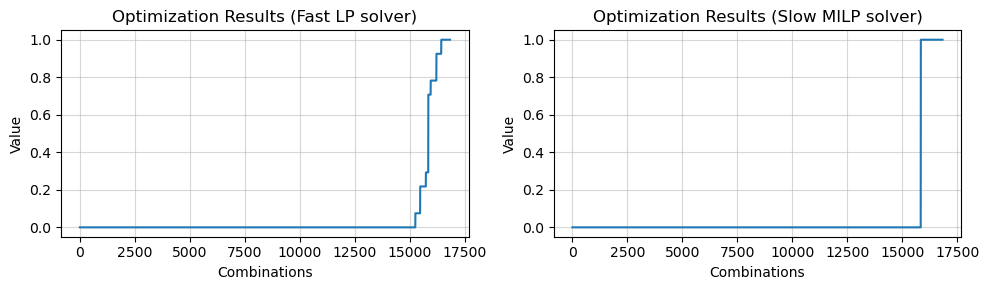

Optimal police car locations found: 4/4 in 12.19 seconds: [1303773676 1068403788  901799182    3173240]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 707133.5950 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 1.23 s
Wall time: 26.6 s


In [56]:
%%time
optimal_police_locations = run_solvers(problem, nr_of_locations=K, solver_name='PULP_CBC_CMD', plot=True)

#### 2.4 COIN_CMD (COIN-OR Command Line)

In [57]:
%%time
optimal_police_locations = run_solvers(problem, nr_of_locations=K, solver_name='COIN_CMD', plot=False)

COIN_CMD with LP relaxation only found 2/4 locations in 1.31 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 12.56 seconds: [1303773676 1068403788  901799182    3173240]
Solver: COIN_CMD | Status: 1 (Optimal)
Objective function value (total response time): 707133.5950 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 984 ms
Wall time: 26.1 s


#### 2.5 GLPK_CMD (GNU Linear Programming Kit)

In [59]:
%%time
optimal_police_locations = run_solvers(problem, nr_of_locations=K, solver_name='GLPK_CMD', plot=False)

GLPK_CMD with LP relaxation only found 2/4 locations in 9.94 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 12.72 seconds: [1303773676 1068403788  901799182    3173240]
Solver: GLPK_CMD | Status: 1 (Optimal)
Objective function value (total response time): 707133.5950 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 906 ms
Wall time: 2min 29s


#### 2.6 HiGHS_CMD (High-Performance Solver)

In [58]:
%%time
optimal_police_locations = run_solvers(problem, nr_of_locations=K, solver_name='HiGHS', plot=False)

HiGHS with LP relaxation only found 2/4 locations in 1.02 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 12.06 seconds: [1303773676 1068403788  901799182    3173240]
Solver: HiGHS | Status: 1 (Optimal)
Objective function value (total response time): 707133.5950 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 8.73 s
Wall time: 20.7 s


### 3.0 Exploring solver arguments
Obs: Be aware that for some solvers, having the binary version installed is necessary for certain arguments to work, compared to using th api version.   
However, it can be hard knowing if an argument is used or not as the api solver does not throw errors if arguments are invalid.

#### 3.1 PULP_CBC_CMD (COIN-OR Branch and Cut)

These are the same arguments for the COIN_CMD solver, as they are both using the COIN-OR Branch and Cut solver.

In [ ]:
%%time
status = problem.solve(pulp.PULP_CBC_CMD(mip=False, msg=False, gapRel=0.9, warmStart=True, strong=True, cuts=True, options=['presolve', 'on'])) # runtime 10.7 sec
# status = problem.solve(pulp.PULP_CBC_CMD(mip=False, msg=False, gapRel=0.001, warmStart=False)) # runtime 10.9 sec
# status = problem.solve(pulp.PULP_CBC_CMD(mip=False)) # runtime 10.6 sec
# status = problem.solve(pulp.PULP_CBC_CMD()) # runtime 1min 7sec

# status = problem.solve(pulp.PULP_CBC_CMD(
#     mip=False,  # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
#     msg=False,  # Enable solver messages for more insight into the solving process
#     timeLimit=60,  # Limit the solver to 60 seconds
#     # gapRel=0.9,  # Accept a solution within 10% of the optimum
#     presolve=True,  # Enable presolve to simplify the problem before solving
#     warmStart=True,  # Use a warm start to speed up the solving process
#     strong=True,  # Use a limited number of strong branching candidates for a balance between speed and accuracy
#     cuts=True,  # Enable all available cuts
#     threads=1,  # Sets the maximum number of threads to be used by the solver (not working)
# ))

# status = problem.solve(pulp.COIN_CMD(mip=False, msg=False, gapRel=0.9, warmStart=True, strong=True, cuts=True, options=['presolve', 'on'])) # runtime 10.9 sec
# status = problem.solve(pulp.COIN_CMD(mip=False, msg=False, gapRel=0.000001, warmStart=False)) # runtime 10.6 sec
# status = problem.solve(pulp.COIN_CMD(mip=False)) # runtime 10.5 sec
# status = problem.solve(pulp.COIN_CMD()) # runtime 1min 7sec

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

In [69]:
status = problem.solve(pulp.COIN_CMD(mip=False, msg=True, gapAbs=100,
    options=[
    "presolve on",
    "gomory on",
    "cuts on",
    "heuristics on",
    "strongBranching on",
    "sec 120",  # Allowing more time for this complex problem
    "strategy probing",  # Advanced strategy settings
]))
print(f"Binary Solver Status: {pulp.LpStatus[status]}, Objective: {pulp.value(problem.objective)}")

Binary Solver Status: Optimal, Objective: 2026355.2689999996


In [62]:
status = problem.solve(pulp.COIN_CMD(mip=False, msg=True, options=[
    "presolve off",
    "gomory off",
    "cuts off",
    "heuristics off",
    "strongBranching off",
    "sec 120",  # Allowing more time for this complex problem
    "strategy probing",  # Advanced strategy settings
]))
print(f"Binary Solver Status: {pulp.LpStatus[status]}, Objective: {pulp.value(problem.objective)}")

Binary Solver Status: Optimal, Objective: 2026355.2689999996



#### 2.4 GLPK (GNU Linear Programming Kit)

In [23]:
%%time
# GLPK VERSION 1: Ideal settings
status = problem.solve(pulp.GLPK_CMD(
    mip=True,  # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
    msg=False,  # Display solver output for more insight
    timeLimit=120,  # Solver time limit set to 60 seconds
    options=['--presol', '--cuts', '--mipgap', '0.1']
))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 2026355.27 seconds, or 33772.59 minutes, or 562.88 hours
CPU times: total: 953 ms
Wall time: 1min 15s


In [24]:
%%time
# GLPK VERSION 2: Alternative settings
status = problem.solve(pulp.GLPK_CMD(
    mip=False,  # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
    msg=False,  # Display solver output for more insight
    timeLimit=120  # Solver time limit set to 60 seconds
    options=['--presol', '--cuts', '--mipgap', '0.1'] # presolve=True, cuts=True, mipgap=0.1
))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 2026355.27 seconds, or 33772.59 minutes, or 562.88 hours
CPU times: total: 1.02 s
Wall time: 48 s


Observations:
- Original Settings: ``mip=True`` resulted in a solution, after 1min 7sec.
- Alternative Settings: ``mip=False`` resulted in a solution, after 50sec.

Again, relaxing the integer variable constraint resulted in reaching the same optimal solution faster.

#### 2.5 HiGHS (High-Performance Solver)

In [25]:
%%time

# HiGHS VERSION 1: Ideal settings
# status = problem.solve(pulp.HiGHS(mip=True, msg=False, options=['presolve', 'on'], timeLimit=60, gapRel=0.1, threads=12))
status = problem.solve(pulp.HiGHS(
    mip=True, # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
    msg=False, 
    # timeLimit=60,  # Solver time limit set to 60 seconds
    # threads=6,  # Adjust based on your system's CPU capabilities (not working)
    mip_rel_gap=9999999,
    parallel="on",
    presolve="on",
))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 803200.27 seconds, or 13386.67 minutes, or 223.11 hours
CPU times: total: 1.64 s
Wall time: 1.99 s


In [80]:
# check if HiGHS is installed properly
print(pulp.HiGHS().available())

True


In [81]:
# check if HiGHs can use parallel processing
# print(pulp.HiGHS().parallel())
h = highspy.Highs()

In [88]:
from highspy import Highs
h.setOptionValue("parallel", 1)

<HighsStatus.kError: -1>

In [86]:
h.setOptionValue("threads", 12)

<HighsStatus.kOk: 0>

In [84]:
h.setOptionValue("presolve", 1)

<HighsStatus.kError: -1>

In [92]:
%%time
# HiGHS VERSION 2: Alternative settings
# status = problem.solve(pulp.HiGHS(mip=True, msg=False, options=['presolve', 'on'], timeLimit=60, gapRel=0.1, threads=12))
status = problem.solve(pulp.HiGHS(
    mip=True, # mip=True since have binary variables. mip=False can sometimes be faster, but result might be invalid
    msg=False,
    presolve="on",
    parallel="on", # parallellization for MILP; developers:"hoped that this will be implemented before the end of 2024"
    options=[
        # "presolve=off",  # Enable presolving to simplify the problem before solving
        "parallel=on",  # Enable parallel solving if supported
        # "--parallel",  # Enable parallel solving if supported
    #     "time_limit=60",  # Set a time limit to ensure the solver doesn't run indefinitely
    #     "simplex_dualise=on",  # Use the dual simplex algorithm for LP relaxation
    #     "simplex_crash=on",  # Use a crash algorithm to find a good starting basis for the simplex
    #     "simplex_strategy=6",  # Use a strategy that balances between speed and precision
    #     "mip_gap=0.1"  # Accept a solution within 5% of the optimal (relaxes accuracy for speed)
    ],
    # threads=12  # Adjust based on your system's CPU capabilities (not working)
))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 707133.60 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 6.53 s
Wall time: 7.67 s


In [51]:
%%time
status = problem.solve(pulp.HiGHS(mip=True, msg=False, parallel="on", options=["parallel=on"]))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 707133.60 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 6.02 s
Wall time: 7.79 s


In [52]:
%%time
status = problem.solve(pulp.HiGHS(mip=True, msg=False, parallel="off", options=["parallel=off"]))

# inspect the status of the solution
print(f"status: {problem.status}, {pulp.LpStatus[problem.status]}")
print(f"Objective function value: {pulp.value(problem.objective):.2f} seconds, or {pulp.value(problem.objective)/60:.2f} minutes, or {pulp.value(problem.objective)/3600:.2f} hours")

status: 1, Optimal
Objective function value: 707133.60 seconds, or 11785.56 minutes, or 196.43 hours
CPU times: total: 6.5 s
Wall time: 7.62 s


Observations:
- Original Settings: ``mip=True`` resulted in a solution, after 15sec.
- Alternative Settings: ``mip=False`` resulted in a solution, after 14.2sec. (13.9sec with ``presolve=off``)

Again, relaxing the integer variable constraint resulted in reaching the same optimal solution faster.

## 3.0 Conclusion

| Solver                    | Runtime (Integer Constraints) | Runtime (Relaxed Constraints) |
|---------------------------|-------------------------------------|--------------------------------------|
| PULP_CBC (COIN-OR Branch and Cut) | 1min 25sec                          | 10 seconds                           |
| GLPK (GNU Linear Programming Kit) | 1min 7sec                           | 50 seconds                           |
| HiGHS (High-Performance Solver)    | 15 seconds                          | 14.2 seconds                         |



Conclusion:  
``PULP_CBC`` and ``COIN_CMD`` is the same solver, with same performance. Did not find any extra arguments for the binary install that made a big difference.  
The ``HiGHS`` solver is faster for LP problems, where it can utilize max parallel processing. Since parallel processing is not yet developed for MIP problems, the `HiGHS` solver is on par with ``PULP_CBC`` and ``COIN_CMD`` for MILP problems.    
``GLPK`` solver is the slowest and should be avoided for this kind of problem.

*HiGHS developers - Future plans: The MIP solver has been written with parallel tree seach in mind, and it is hoped that this will be implemented before the end of 2024.*



Note: relaxing integer constraints can drastically reduce complexity and, consequently, the solving time. This is expected behavior as integer programming problems are generally NP-hard, while their linear programming counterparts (with relaxed integer constraints) can be solved in polynomial time.